# Lab DFT 信号生成与频域分解
## 信号生成

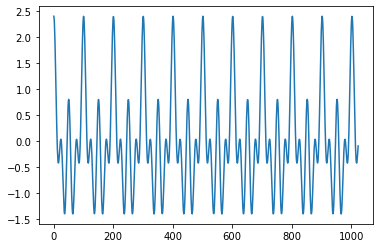

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sinusoid(N, A, f0, fs, phi):
 '''
 N(int) : number of samples
 A(float) : amplitude
 f0(float): frequency in Hz
 fs(float): sample rate
 phi(float): initial phase
 
 return 
 x (numpy array): sinusoid signal which lenght is M
 '''
 
 T = 1/fs
 n = np.arange(N) # [0,1,..., N-1]
 x = A * np.cos( 2*f0*np.pi*n*T + phi )
 
 return x

N = 1024
A = 0.8
f0 = 440
fs = 44100
phi = 0

x = generate_sinusoid(N, A, f0, fs, phi) + generate_sinusoid(N, A, 2*f0, fs, phi)+ generate_sinusoid(N, A, 4*f0, fs, phi)

plt.plot(x)
plt.show()

# DFT分析

In [2]:
def generate_complex_sinusoid(k, N):
 '''
 k (int): frequency index
 N (int): length of complex sinusoid in samples
 
 returns
 c_sin (numpy array): the generated complex sinusoid (length N)
 '''
 
 n = np.arange(N)
 
 c_sin = np.exp(1j * 2 * np.pi * k * n / N)
 
 return np.conjugate(c_sin)

def generate_complex_sinusoid_matrix(N):
 '''
 N (int): length of complex sinusoid in samples
 
 returns
 c_sin_matrix (numpy array): the generated complex sinusoid (length N)
 '''
 
 n = np.arange(N)
 n = np.expand_dims(n, axis=1)  # 扩充维度，将1D向量，转为2D矩阵，方便后面的矩阵相乘
 
 k = n
 
 m = n.T * k / N     # [N,1] * [1, N] = [N,N]
 
 S = np.exp(1j * 2 * np.pi * m)  # 计算矩阵 S
 
 return np.conjugate(S)

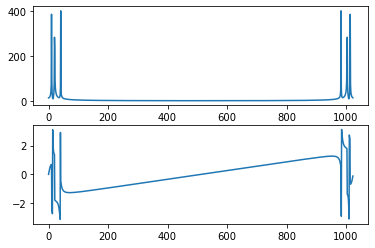

In [3]:
S = generate_complex_sinusoid_matrix(N)
X_2 = np.dot(S, x)

mX = np.abs(X_2)
pX = np.angle(X_2)

# plot the magnitude and phase
plt.subplot(2,1,1)
plt.plot(mX)

plt.subplot(2,1,2)
plt.plot(pX)
plt.show()

## PYNQ加速的DFT

In [4]:
from pynq import Overlay
overlay = Overlay("./dft.bit")
dft = overlay.dft_0

In [5]:
from pynq import allocate
sample_len = len(x)
inputre_buffer = allocate(shape=(sample_len,), dtype='float')
inputim_buffer = allocate(shape=(sample_len,), dtype='float')
outputre_buffer = allocate(shape=(sample_len,), dtype='float')
outputim_buffer = allocate(shape=(sample_len,), dtype='float')

In [6]:
np.copyto(inputre_buffer, X_2.real)
np.copyto(inputim_buffer, X_2.imag)
np.copyto(outputre_buffer, X_2.real)
np.copyto(outputim_buffer, X_2.imag)

In [7]:
dft.s_axi_control.write(0x10,inputre_buffer.physical_address)
dft.s_axi_control.write(0x1c,inputim_buffer.physical_address)
dft.s_axi_control.write(0x28,outputre_buffer.physical_address)
dft.s_axi_control.write(0x34,outputim_buffer.physical_address)

In [8]:
import time

dft.s_axi_CTRL.write(0x00, 0x00)
start_time = time.time()
while True:
    reg = dft.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.0011632442474365234s


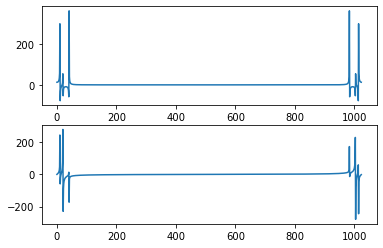

In [9]:
# plot the magnitude and phase
plt.subplot(2,1,1)
plt.plot(outputre_buffer)

plt.subplot(2,1,2)
plt.plot(outputim_buffer)
plt.show()